# Exercise solutions

### 12. Batch Gradient Descent with early stopping for Softmax Regression
(without using Scikit-Learn)

Let's start by loading the data. We will just reuse the Iris dataset we loaded earlier.

In [ ]:

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]



We need to add the bias term for every instance ($x_0 = 1$):

In [ ]:

X_with_bias = np.c_[np.ones([len(X), 1]), X]


And let's set the random seed so the output of this exercise solution is reproducible:


In [ ]:

np.random.seed(2042)



The easiest option to split the dataset into a training set, a validation set and a test set would be to use Scikit-Learn's `train_test_split()` function, but the point of this exercise is to try understand the algorithms by implementing them manually. So here is one possible implementation:


In [ ]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]


The targets are currently class indices (0, 1 or 2), but we need target class probabilities to train the Softmax Regression model. Each instance will have target class probabilities equal to 0.0 for all classes except for the target class which will have a probability of 1.0 (in other words, the vector of class probabilities for ay given instance is a one-hot vector). Let's write a small function to convert the vector of class indices into a matrix containing a one-hot vector for each instance:


In [ ]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

Let's test this function on the first 10 instances:



In [ ]:
y_train[:10]
to_one_hot(y_train[:10])

Looks good, so let's create the target class probabilities matrix for the training set and the test set:


In [ ]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

Now let's implement the Softmax function. Recall that it is defined by the following equation:

$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$



In [ ]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums


We are almost ready to start training. Let's define the number of inputs and outputs:


In [ ]:

n_inputs = X_train.shape[1] # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))   # == 3 (3 iris classes)




Now here comes the hardest part: training! Theoretically, it's simple: it's just a matter of translating the math equations into Python code. But in practice, it can be quite tricky: in particular, it's easy to mix up the order of the terms, or the indices. You can even end up with code that looks like it's working but is actually not computing exactly the right thing. When unsure, you should write down the shape of each term in the equation and make sure the corresponding terms in your code match closely. It can also help to evaluate each term independently and print them out. The good news it that you won't have to do this everyday, since all this is well implemented by Scikit-Learn, but it will help you understand what's going on under the hood.

So the equations we will need are the cost function:

$J(\mathbf{\Theta}) =
- \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

And the equation for the gradients:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

Note that $\log\left(\hat{p}_k^{(i)}\right)$ may not be computable if $\hat{p}_k^{(i)} = 0$. So we will add a tiny value $\epsilon$ to $\log\left(\hat{p}_k^{(i)}\right)$ to avoid getting `nan` values.



In [ ]:
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients


And that's it! The Softmax model is trained. Let's look at the model parameters:

Theta

Let's make predictions for the validation set and check the accuracy score:




In [ ]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

Well, this model looks pretty good. For the sake of the exercise, let's add a bit of $\ell_2$ regularization. The following training code is similar to the one above, but the loss now has an additional $\ell_2$ penalty, and the gradients have the proper additional term (note that we don't regularize the first element of `Theta` since this corresponds to the bias term). Also, let's try increasing the learning rate `eta`.


In [ ]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

Because of the additional $\ell_2$ penalty, the loss seems greater than earlier, but perhaps this model will perform better? Let's find out:



In [ ]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

Cool, perfect accuracy! We probably just got lucky with this validation set, but still, it's pleasant.

Now let's add early stopping. For this we just need to measure the loss on the validation set at every iteration and stop when the error starts growing.


In [ ]:
eta = 0.1 
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "early stopping!")
        break

logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score


Still perfect, but faster.
Now let's plot the model's predictions on the whole dataset:


In [ ]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()


And now let's measure the final model's accuracy on the test set:

In [ ]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

Our perfect model turns out to have slight imperfections. This variability is likely due to the very small size of the dataset: depending on how you sample the training set, validation set and the test set, you can get quite different results. Try changing the random seed and running the code again a few times, you will see that the results will vary.

# Linear Regression
$$\hat{y}=\theta x$$
- cost funciton
$$
MSE(X, h_{\theta})=\frac{1}{m}\sum_{i=1}^{m}(\theta^T x^{(i)}-y^{(i)})^2
$$

## Normal Equation

$$
\hat{\theta}=(X^T X)^{-1}X^T y
$$

In [1]:
import numpy as np
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

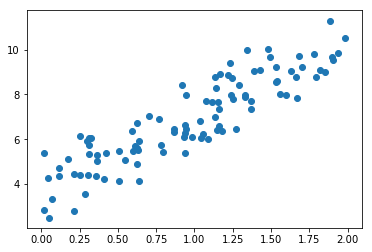

In [2]:
import matplotlib.pyplot as plt
plt.scatter(X, y)
plt.show()

In [3]:
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [4]:
theta_best

array([[ 3.7799554 ],
       [ 3.21195542]])

In [5]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_pred = X_new_b.dot(theta_best)
y_pred

array([[  3.7799554 ],
       [ 10.20386625]])

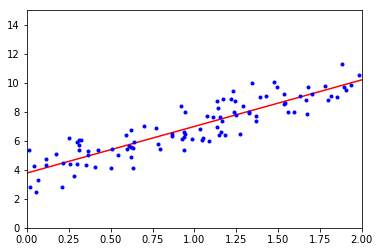

In [6]:
plt.plot(X_new, y_pred, 'r-')
plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])
plt.show()

In [7]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([ 3.7799554]), array([[ 3.21195542]]))

In [8]:
lin_reg.predict(X_new)

array([[  3.7799554 ],
       [ 10.20386625]])

# Gradient Descent

## Batch Gradient Descent
$$
\frac{\partial}{\partial \theta_j}MSE(\theta)=\frac{2}{m}\sum_{i=1}^{m}(\theta^T x^{(i)} - y^{(i)})x_j^{(i)}
$$

$$
\nabla_{\theta}MSE(\theta)=\frac{2}{m}X^T (X\theta - y)
$$

In [9]:
learning_rate = 0.1
n_epochs = 1000
m = 100
theta = np.random.randn(2,1)
for epochs in range(n_epochs):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - learning_rate*gradients

In [10]:
theta

array([[ 3.7799554 ],
       [ 3.21195542]])

## Stochastic Gradient Descent

In [12]:
n_epochs = 50
t0, t1 = 5, 50
def learning_schedule(t):
    return t0/(t+t1)
theta = np.random.randn(2,1)
for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradient = 2 / 1 * xi.T.dot(xi.dot(theta) -yi)
        learning_rate = learning_schedule(epoch * m + i)
        theta = theta - learning_rate * gradient

In [13]:
theta

array([[ 3.74456229],
       [ 3.21481434]])

## Mini-batch Gradient Descent

In [23]:
m, n = X_b.shape
batch_size = 20
n_batches = int(np.ceil(m / batch_size))
def fetch_data(epoch, batch_idx, batch_size):
    np.random.seed(42+epoch*batch_idx)
    indices = np.random.randint(m, size=batch_size)
    return X_b[indices], y[indices].reshape(-1,1)

In [28]:
n_epoch = 10000
theta = np.random.randn(2,1)
for epoch in range(n_epoch):
    for batch in range(n_batches):
        X_batch, y_batch = fetch_data(epoch, batch, batch_size)
        gradient = 2/batch_size * X_batch.T.dot(X_batch.dot(theta) - y_batch)
        learing_rate = learning_schedule(epoch*n_batches+batch)
        theta = theta - learing_rate * gradient

In [29]:
theta

array([[ 3.88568782],
       [ 3.16741953]])

# Polynomial Regression

In [30]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

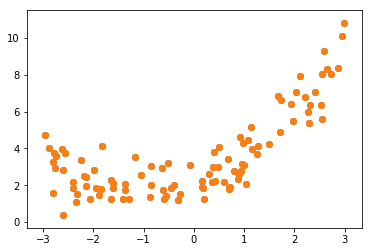

In [32]:
plt.scatter(X, y)
plt.show()

In [38]:
from sklearn.preprocessing import PolynomialFeatures
poly_featrues = PolynomialFeatures(degree=2,include_bias=False)
X_poly = poly_featrues.fit_transform(X)
X[0]

array([ 2.53590449])

In [39]:
X_poly[0]

array([ 2.53590449,  6.43081157])

In [40]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([ 2.15617027]), array([[ 0.96289516,  0.48178778]]))

In [44]:
x = np.linspace(-3, 3, 100).reshape(100, 1)
y_pred = lin_reg.predict(poly_featrues.fit_transform(x))

In [45]:
plt.scatter(X, y)
plt.plot(x, y_pred)

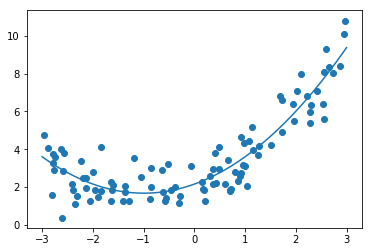

In [46]:
plt.show()

# Learning Curve

In [50]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m],y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_absolute_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_absolute_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='train')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='val')
    plt.legend(loc='best')

In [51]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

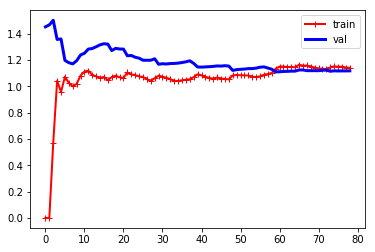

In [52]:
plt.show()

In [54]:
from sklearn.pipeline import Pipeline
polynomial_pipe = Pipeline([
    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
    ('sdg_reg', LinearRegression())
])
plot_learning_curves(polynomial_pipe, X, y)

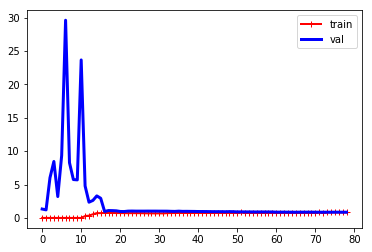

In [55]:
plt.show()

# Regularized Linear Model
### Ridge Regression
$$
J(\Theta)=MSE(\theta)+\alpha \frac{1}{2}\sum_{i=1}^{n}\theta_i^2
$$

In [56]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
params = [
    {'alpha':[0.1, 1, 10]}
]
ridge = Ridge(solver='cholesky')
grid_search = GridSearchCV(ridge, params, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] alpha=0.1 .......................................................
[CV] alpha=0.1 .......................................................
[CV] alpha=0.1 .......................................................
[CV] alpha=1 .........................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=1 .........................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] .......................................... alpha=1, total=   0.0s
[CV] alpha=1 .........................................................
[CV] alpha=10 ........................................................
[CV] .......................................... alpha=1, total=   0.0s
[CV] alpha=10 ........................................................
[CV] .............

[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.1s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='cholesky', tol=0.001),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'alpha': [0.1, 1, 10]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=2)

In [58]:
grid_search.best_estimator_

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='cholesky', tol=0.001)

### Lasso Regression
$$
J(\Theta)=MSE(\theta)+\alpha\sum_{i=1}^{n}|\theta_i|
$$

In [60]:
from sklearn.linear_model import Lasso
params = [
    {'alpha':[0.1, 1, 10]}
]
lasso = Lasso()
grid_search = GridSearchCV(lasso, params, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] alpha=0.1 .......................................................
[CV] alpha=0.1 .......................................................
[CV] alpha=1 .........................................................
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] .......................................... alpha=1, total=   0.0s
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=1 .........................................................
[CV] alpha=1 .........................................................
[CV] alpha=10 ........................................................
[CV] alpha=10 ........................................................
[CV] ......................................... alpha=10, total=   0.0s
[CV] .............

[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.1s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'alpha': [0.1, 1, 10]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=2)

In [61]:
grid_search.best_estimator_

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

### Elastic Net
$$
J(\Theta)=MSE(\theta)+\gamma\alpha\sum_{i=1}^{n}|\theta_i|+\frac{1-\gamma}{2}\alpha\sum_{i=1}^{n}\theta_i^2
$$

In [62]:
from sklearn.linear_model import ElasticNet
params=[
    {'alpha':[0.1,1,10], 'l1_ratio':[0.2, 0.5, 0.8]},
]
elastic_net = ElasticNet()
grid_search = GridSearchCV(elastic_net, params, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] alpha=0.1, l1_ratio=0.2 .........................................
[CV] alpha=0.1, l1_ratio=0.2 .........................................
[CV] alpha=0.1, l1_ratio=0.2 .........................................
[CV] .......................... alpha=0.1, l1_ratio=0.2, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.5 .........................................
[CV] .......................... alpha=0.1, l1_ratio=0.2, total=   0.0s
[CV] .......................... alpha=0.1, l1_ratio=0.5, total=   0.0s
[CV] .......................... alpha=0.1, l1_ratio=0.2, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.5 .........................................
[CV] alpha=0.1, l1_ratio=0.5 .........................................
[CV] .......................... alpha=0.1, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.8 .........................................
[CV] .......................... alpha=0.1, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.1, l

[Parallel(n_jobs=-1)]: Done   6 out of  27 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.1s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'alpha': [0.1, 1, 10], 'l1_ratio': [0.2, 0.5, 0.8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [63]:
grid_search.best_estimator_

ElasticNet(alpha=1, copy_X=True, fit_intercept=True, l1_ratio=0.2,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

# Logitstic Regression

- cost function
$$
J(\Theta)=-\frac{1}{m}\sum_{i=1}^{m}\big[y^{(i)}log(\hat{p}^{(i)}) + (1-y^{i})log(1-\hat{p}^{(i)})\big]
$$

In [64]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris)

['data', 'target', 'target_names', 'DESCR', 'feature_names']

In [66]:
X = iris['data'][:, 3:]
y = (iris['target']==2).astype(np.int)

In [67]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

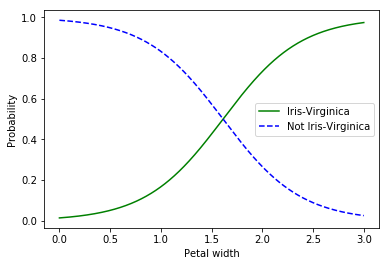

In [69]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:,1], 'g-', label='Iris-Virginica')
plt.plot(X_new, y_proba[:, 0], 'b--', label='Not Iris-Virginica')
plt.legend(loc='best')
plt.xlabel('Petal width')
plt.ylabel('Probability')
plt.show()

# Softmax Regression

In [71]:
X = iris['data'][:, (2,3)]
y = iris['target']
softmax_regression = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10)
softmax_regression.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)